# Predicción de Deserción de Clientes Bancarios con Machine Learning:
**Estrategias de Machine Learning para Mejorar la Retención de Clientes**

**Contexto**

En la actualidad, la retención de clientes es un aspecto fundamental para cualquier empresa, y el sector bancario no es la excepción. Beta Bank ha identificado que, mes a mes, un número considerable de sus clientes están abandonando el banco. Dado que es más rentable retener a los clientes actuales que adquirir nuevos, surge la necesidad de desarrollar un modelo de aprendizaje automático capaz de predecir si un cliente abandonará la institución en el futuro.

**Objetivo del Proyecto**

El propósito principal de este estudio es crear un modelo de clasificación que prediga con la mayor precisión posible si un cliente dejará el banco. Para evaluar su desempeño, utilizaremos la métrica F1-score, asegurándonos de que alcance al menos un valor de 0.59 en el conjunto de prueba. Además, analizaremos la métrica AUC-ROC para comparar su capacidad de discriminación entre clases.

**Enfoque y Metodología**

El desarrollo del modelo se llevará a cabo siguiendo los siguientes pasos:

1. Carga y exploración de datos: Se analizará el conjunto de datos proporcionado en el archivo /datasets/Churn.csv, el cual contiene información detallada sobre el comportamiento pasado de los clientes, incluyendo variables como edad, saldo de cuenta, historial de crédito, actividad y número de productos bancarios utilizados.
2. Análisis del equilibrio de clases: Se evaluará la distribución de la variable objetivo (Exited), que indica si un cliente ha abandonado el banco o no.
3. Entrenamiento inicial del modelo: Se entrenará un modelo base sin realizar ajustes en el equilibrio de clases para establecer un punto de referencia en cuanto a su rendimiento.
4. Optimización del modelo: Se implementarán al menos dos estrategias para tratar el desequilibrio de clases, como el ajuste de pesos (class_weight='balanced') y la optimización del umbral de decisión. Se evaluarán distintos algoritmos y combinaciones de hiperparámetros para encontrar el modelo más eficiente.
5. Prueba final y evaluación: Se aplicará el modelo en el conjunto de prueba, verificando el F1-score y calculando la métrica AUC-ROC, lo que permitirá comparar su desempeño global

**Importancia del Proyecto**

Un modelo eficiente de predicción de abandono permitirá a Beta Bank implementar estrategias preventivas, personalizar ofertas y mejorar la experiencia del cliente, reduciendo la tasa de deserción y optimizando la rentabilidad del negocio.

Este proyecto, por lo tanto, no solo representa un desafío técnico en el ámbito del Machine Learning, sino también una oportunidad para mejorar la toma de decisiones estratégicas en el sector financiero.

## Carga y exploración de datos

El primer paso es cargar todas las librerías necesarias para el proyecto:

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np

El segundo paso es cargar los datos y analizar su contenido:

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

Verificamos la estructura del dataframe para analizar los tipos de datos disponibles:

In [3]:
data.info()
data.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Debido a que hay 700 valores nulos en la columna Tenure, podemos rellenarlos con la mediana.

In [4]:
data = data.fillna(data['Tenure'].median())

Ahora podemos analizar el contenido de las características.

In [5]:
rows, cols = data.shape
print(f"Número de filas: {rows} Número de columnas:{cols}")
print(data.dtypes)
print(data.head(5))

Número de filas: 10000 Número de columnas:14
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1      

Podemos observar que hay 13 columnas con características y 1 con el objetivo, pero sólo 10 de ellas tienen información potencial para determinar si un cliente abandonaran el banco o no. En este caso el apellido, el id y el número de fila no influyen en esta clasificación, por lo que no se tomarán en cuenta. Sin embargo, hay características que sí son importantes, tales como Gender y Geography, pero que son categóricas y difieren de las númericas. Por lo que resultará útil transformarlas a su forma númerica para posteriormente realizar un escalado de todas las características y así evitar que el modelo le asigne mayor valor a las cifras grandes.

### Codificación de variables categóricas

Como se mencionó anteriormente, es necesario transformar las características Geography y Gender a su forma númerica para equipararlas con las demás.

In [6]:
# Recurrimos a One Hot Encoding y especificamos el parámetro drop_first para evitar la trampa dummy
data_ohe = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)
print(data_ohe.head(5))

   RowNumber  CustomerId   Surname  CreditScore  Age  Tenure    Balance  \
0          1    15634602  Hargrave          619   42     2.0       0.00   
1          2    15647311      Hill          608   41     1.0   83807.86   
2          3    15619304      Onio          502   42     8.0  159660.80   
3          4    15701354      Boni          699   39     1.0       0.00   
4          5    15737888  Mitchell          850   43     2.0  125510.82   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              1          1               1        101348.88       1   
1              1          0               1        112542.58       0   
2              3          1               0        113931.57       1   
3              2          0               0         93826.63       0   
4              1          1               1         79084.10       0   

   Geography_Germany  Geography_Spain  Gender_Male  
0                  0                0            0  
1         

Ahora, el siguiente paso es definir cuáles serán las características que utilizaremos para entrenar al modelo y cuál será la característica objetivo.

### División de datos

In [7]:
# Usamos drop para eliminar todas las columnas irrelevantes. incluyendo Exited
features = data_ohe.drop(columns= ['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)

# Exited es nuestro objetivo porque nos dice si un cliente ha abandonado o no el banco
target = data_ohe['Exited']

El siguiente paso es hacer la división del conjuntos de datos en entrenamiento y validación.

In [8]:
# El 75% de los datos está destinado al entrenamiento y el 25% a la validación
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

### Escalado de características 

Posteriormente, podemos hacer el escalado de las características para igualar las escalas y evitar que el modelo le de mayor importancia a las cifras grandes como las de EstimatedSalary.

In [9]:
""" Pruebo a graficar histogramas de las variables para determinar si los datos tienen una distribución normal o no
# data.hist()
#plt.show() """

# Debido a que no todos los datos son normales, procedo a hacer un escalado de Normalización.
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

scaler = MinMaxScaler() # Creamos el objeto MinMaxScaler()
scaler.fit(features_train[numeric]) # Ajustamos el scaler a los datos de entrenamiento con las características numéricas

features_train_scaled = scaler.transform(features_train[numeric]) # Transformamos los datos de entrenamiento..
features_valid_scaled = scaler.transform(features_valid[numeric]) #... y validación para que tengan los datos escalados

features_train = features_train.copy() # Nos aseguramos de que estos DataFrames son independientes... 
features_valid = features_valid.copy() # ...haciendo una copia de ellos

features_train[numeric] = features_train_scaled # Remplazamos las columnas correspondientes con los datos escalados
features_valid[numeric] = features_valid_scaled # De esta forma seguimos teniendo nuestras variables originales pero con los datos escalados

#print(features_train)
#print(features_valid)

##  Análisis del equilibrio de clases

El siguiente paso es analizar equilibrio de clases y determinar si hay un desbalance, para ello podemos contar la cantidad de clases que hay en nuestro objetivo.

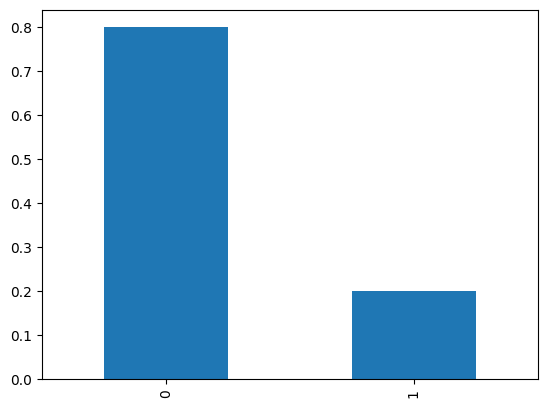

In [10]:
class_frequency = target_train.value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.show()

Como podemos observar, existe un desequilibrio de clases donde 0 predomina. Lo que se traduce a que conocemos más información de clientes que se han quedado en el banco que de los que no. Por el momento no ajustaremos las clases para ver como se comporta el modelo, pero si es necesario, más adelante haremos un balanceo.

## Entrenamiento de los modelos

#### Bosque Aleatorio

Ahora sí, podemos pasar al entrenamiento de los modelos. En primer lugar, evaluaremos un Bosque aleatorio y ajustaremos sus hiperparámetros para encontrar la mejor combinación de estos.

In [11]:
# Creamos una función que intenté distintas combinaciones de estimators y depth y encuentré el valor F1 más alto
def find_the_best(features_train, target_train, features_valid, target_valid):
    best_f1_score = 0 # Iniciamos un contador vacío
    for n in range(1, 11): # Usaremos un bucle for para ajustar n_estimators en un rango de 1 a 10
        for depth in range(1, 11): # Lo mismo para depth
            model = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=depth) # Definimos nuestro modelo
            model.fit(features_train, target_train) # Entrenamos el modelo con los datos de entrenamiento.
            valid_prediction = model.predict(features_valid) # Realizamos predicciones con el conjunto de validación
            score_f1 = f1_score(target_valid, valid_prediction) # Evaluamos el balance en la predicción de las clases
            
            if score_f1 > best_f1_score: # Comparamos los F1 scores entre las distintas combinaciones
                best_f1_score = score_f1 # Si es el mejor puntaje, se actualizarán las variables:
                best_estimators = n
                best_depth = depth

    return best_f1_score, best_estimators, best_depth

best_f1_score, best_estimators, best_depth = find_the_best(features_train, target_train, features_valid, target_valid)

print(f"El valor más alto de F1 score es : {best_f1_score} RandomForest: n_estimators = {best_estimators}, max_depth = {best_depth}")        

El valor más alto de F1 score es : 0.5669481302774427 RandomForest: n_estimators = 6, max_depth = 7


Como podemos observar en el código anterior, el valor más alto de F1 score fue de 0.5669, con 6 estimadores y 7 como profundidad máxima. Lo que esto significa es que nuestro modelo no es bueno ni malo identificando verdaderos positivos y es regular minimizando los falsos positivos y negativos. Por lo que es posible mejorar esta métrica.

#### Modelo de Regresión Logística:

In [12]:
model_l = LogisticRegression(random_state=54321, solver='liblinear') # En este modelo no se cambian los hiperparámetros, sólo se asigna el algoritmo que optimiza el modelo
model_l.fit(features_train, target_train) # Se entrena el modelo
predictions = model_l.predict(features_valid) # Realizamos predicciones con el conjunto de validación
score_f1 = f1_score(target_valid, predictions) # Evaluamos el balance en la predicción de las clases
print(f"LogisticRegression, F1 Score = {score_f1}")


LogisticRegression, F1 Score = 0.2828854314002829


El puntaje de F1 de la Regresión Logística es más baja que el de los Bosques Aleatorios, así que podemos tomar este último modelo como referencia y buscar mejorar su puntuación. Sin embargo, todavía nos alejamos de nuestro puntaje objetivo, es posible que hacer un balance de clases mejore este número.

## Optimización del modelo:

### Balanceo de clases

Debido a que tenemos más información de las personas que se han quedado en el banco de las que no, es posible igual los datos haciendo un **sobremuestreo** en el que se replicarán aleatoriamente los elementos de la clase minoritaria para igualar la muestra.

#### Sobremuestreo para RandomForestClassifier

In [13]:
def upsample(features, target, repeat): # Creamos una función para hacer el sobremuestreo
# El paso número 1 es dividir el conjunto de datos de entrenamiento en observaciones negativas y positivas:
    features_zeros = features[target == 0]
    features_one = features[target == 1]
    target_zeros = target[target == 0]
    target_one = target[target == 1]
    
    # Luego, se deben duplicar las observaciones positivas (que son las minoritarias)
    features_upsampled = pd.concat([features_zeros] + [features_one] * repeat) # Concatenamos los duplicados 
    target_upsampled = pd.concat([target_zeros] + [target_one] * repeat)
    # shuffle ordena los elementos en un orden aleatorio.
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    # devolvemos las características y los objetivos balanceados ordenados de forma aleatoria
    return features_upsampled, target_upsampled

# Aplicamos la función a nuestros conjuntos de datos y creamos nuevas variables, especificando los paramétros:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

# Finalmente comprobamos que ambos conjuntos tengan la misma magnitud
print(features_upsampled.shape)
print(target_upsampled.shape)

(21018, 11)
(21018,)


In [14]:
# Ahora podemos entrenar el modelo con los datos sobremuestreados
# Para ello usaremos nuestra función para encontrar la mejor combinación de paramétros y compararlo con el anterior

f1, est, depth = find_the_best(features_upsampled, target_upsampled, features_valid, target_valid)
print(f"El mejor puntaje F1 con los datos sobremuestreados fue de {f1} \nRandomForest: n_estimators =  {est}, max_depth = {depth}")
print()
print(f"El valor más alto de F1 sin el sobremuestreo fue de {best_f1_score} \nRandomForest: n_estimators = {best_estimators}, max_depth = {best_depth}")        

El mejor puntaje F1 con los datos sobremuestreados fue de 0.5568181818181818 
RandomForest: n_estimators =  8, max_depth = 10

El valor más alto de F1 sin el sobremuestreo fue de 0.5669481302774427 
RandomForest: n_estimators = 6, max_depth = 7


Los resultados anteriores demuestran que el modelo no mejoró con el sobremuestreo, pero podemos intentar con el **submuestreo**.

#### Submuestreo para RandomForestClassifier

El submuestreo consiste en eliminar aleatoriamente elementos de la clase mayoritaria para tener un balance de clases.

In [15]:
def downsample(features, target, fraction): # Creamos una función que tomé las características, el objetivo y la fracción de datos que queremos conservar como parámetros
    # El paso número 1 es dividir el conjunto de datos de entrenamiento en observaciones negativas y positivas:
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # Luego vamos a usar sample() para eliminar aleatoriamente una proporción de las observaciones de la clase predominante
    # al mismo tiempo vamos a unir ambos datasets con concat
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    # Ahora vamos a mezclar las filas con shuffle pero con las características aún correspondiendo a su clase
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

# Aplicamos nuestra función a nuestros datos:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
# Y comprobamos la magnitud de ambas clases
print(features_downsampled.shape)
print(target_downsampled.shape)

(2102, 11)
(2102,)


Ahora que tenemos listo el submuestreo, podemos aplicarlo a nuestro modelo:

In [16]:
f1_d, est_d, depth_d = find_the_best(features_downsampled, target_downsampled, features_valid, target_valid)
print(f"El mejor puntaje F1 con los datos submuestreados fue de {f1_d} \nRandomForest: n_estimators =  {est_d}, max_depth = {depth_d}")
print(f"El mejor puntaje F1 con los datos sobremuestreados fue de {f1} \nRandomForest: n_estimators =  {est}, max_depth = {depth}")
print()
print(f"El valor más alto de F1 sin el sobremuestreo fue de {best_f1_score} \nRandomForest: n_estimators = {best_estimators}, max_depth = {best_depth}")        

El mejor puntaje F1 con los datos submuestreados fue de 0.5173210161662818 
RandomForest: n_estimators =  1, max_depth = 4
El mejor puntaje F1 con los datos sobremuestreados fue de 0.5568181818181818 
RandomForest: n_estimators =  8, max_depth = 10

El valor más alto de F1 sin el sobremuestreo fue de 0.5669481302774427 
RandomForest: n_estimators = 6, max_depth = 7


El puntaje F1 disminuyó drásticamente con los datos balanceados con submuestreo, lo que significa que nuestro modelo no esta mejorando.

#### Ajuste de peso de clase para RandomForestClassifier

El ajuste de peso de clase consiste en otorgarle mayor o menor peso a una clase en función de su nivel de importancia para el entrenamiento del modelo.

In [17]:
# Usaremos un nuevo modelo con el ajuste de peso, usaremos la etiqueta 'weight' para distinguir las variables usando este modelo
model_weight = RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators= 6, max_depth=7)
model_weight.fit(features_train, target_train)
predicted_valid_weight = model_weight.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid_weight))

F1: 0.6175040518638574


Gracias al ajuste de clases, el F1 aumentó. Por lo que ahora el modelo toma en cuenta ambas clases para el entrenamiento sin darle preferencia a una sola.

Nuestro puntaje de F1 más alto hasta ahora es de 0.61 con un clasificador de Bosques Aleatorios. Sin embargo, ahora probaremos el balanceo de clases con un modelo de regresión lógica para comprobar las diferencias.

#### Submuestreo con un modelo de Regresión Lógica

In [18]:
model_down = model_l.fit(features_downsampled, target_downsampled) # Se entrena el modelo
predictions_down = model_down.predict(features_valid) # Realizamos predicciones con el conjunto de validación
score_f1_down = f1_score(target_valid, predictions_down) # Evaluamos el balance en la predicción de las clases

print(f"LogisticRegression con submuestreo, F1 Score = {score_f1_down}")

print(f"LogisticRegression con desequilibrio de clases, F1 Score = {score_f1}")


LogisticRegression con submuestreo, F1 Score = 0.4180887372013652
LogisticRegression con desequilibrio de clases, F1 Score = 0.2828854314002829


Como podemos observar, el modelo mejora drásticamente cuando hacemos un balanceo de clases por submuestreo. Ahora probemos con sobremuestreo.

#### Sobremuestreo con un modelo de Regresión Lógica

In [19]:
model_up = model_l.fit(features_upsampled, target_upsampled) # Se entrena el modelo
predictions_up = model_up.predict(features_valid) # Realizamos predicciones con el conjunto de validación
score_f1_up = f1_score(target_valid, predictions_up) # Evaluamos el balance en la predicción de las clases

print(f"LogisticRegression con sobremuestreo, F1 Score = {score_f1_up}")

print(f"LogisticRegression con submuestreo, F1 Score = {score_f1_down}")

print(f"LogisticRegression con desequilibrio de clases, F1 Score = {score_f1}")


LogisticRegression con sobremuestreo, F1 Score = 0.42844677137870857
LogisticRegression con submuestreo, F1 Score = 0.4180887372013652
LogisticRegression con desequilibrio de clases, F1 Score = 0.2828854314002829


El modelo mejora ligeramente, pero el F1 no supera al modelo de RandomForestClassifier.

#### Ajuste de pesos en las clases usando un modelo de Regresión Lógica

In [20]:
model_weight_l = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_weight_l.fit(features_train, target_train)
predicted_valid_weight_l = model_weight_l.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid_weight_l))

F1: 0.5033467202141901


El puntaje mejora pero sin duda RandomForestClassifier se lleva el premio a mejor F1 con su puntaje de 0.61.

### Mejorar F1 con RandomForestClassifier

Me parece prudente que ahora que sabemos que la mejor forma de tratar el desequilibrio de las clases es ajustar sus pesos, podemos buscar la mejor combinación de paramétros con este ajuste. Para ello utilizaremos nuevamente la función find_the_best pero con el parámetro **class_weight='balanced'.**

In [21]:
def find_the_best_2(features_train, target_train, features_valid, target_valid):
    best_f1_score = 0 # Iniciamos un contador vacío
    for n in range(1, 11): # Usaremos un bucle for para ajustar n_estimators en un rango de 1 a 10
        for depth in range(1, 11): # Lo mismo para depth
            model = RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators=n, max_depth=depth) # Definimos nuestro modelo
            model.fit(features_train, target_train) # Entrenamos el modelo con los datos de entrenamiento.
            valid_prediction = model.predict(features_valid) # Realizamos predicciones con el conjunto de validación
            score_f1 = f1_score(target_valid, valid_prediction) # Evaluamos el balance en la predicción de las clases
            
            if score_f1 > best_f1_score: # Comparamos los F1 scores entre las distintas combinaciones
                best_f1_score = score_f1 # Si es el mejor puntaje, se actualizarán las variables:
                best_estimators = n
                best_depth = depth

    return best_f1_score, best_estimators, best_depth

best_f1_score, best_estimators, best_depth = find_the_best_2(features_train, target_train, features_valid, target_valid)

print(f"El valor más alto de F1 score es : {best_f1_score} RandomForest: n_estimators = {best_estimators}, max_depth = {best_depth}")        

El valor más alto de F1 score es : 0.6290322580645161 RandomForest: n_estimators = 7, max_depth = 6


In [25]:
best_model = RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators=7, max_depth=6) 

Como vemos, el valor mejora y ahora tenemos un F1 de 0.62!

### Búsqueda del mejor umbral

In [39]:
best_model.fit(features_train, target_train) #. Entrenamos nuestro mejor modelo encontrado
probabilities_valid = best_model.predict_proba(features_valid) # Calculamos las probabilidades, 
"""predict_proba devuelve un array de probabilidades para cada clase:
Ejemplo: 
array([
    [0.80, 0.20],  # Probabilidad de clase 0 = 80%, Probabilidad de clase 1 = 20%
    [0.30, 0.70],  # Probabilidad de clase 0 = 30%, Probabilidad de clase 1 = 70%
    [0.60, 0.40],  # Probabilidad de clase 0 = 60%, Probabilidad de clase 1 = 40%
])
"""

probabilities_one_valid = probabilities_valid[:, 1] # Calculamos la probabilidad de que la clase sea solo 1

"""
[:, 1] selecciona solo la segunda columna (índice 1), es decir, las probabilidades de la clase positiva (clase 1).
Ahora probabilities_one_valid es un array de una sola dimensión con las probabilidades de que cada muestra sea 
positiva.
Ejemplo: 
array([0.20, 0.70, 0.40, ...])
"""

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    print(f"Threshold = {threshold} | Precision = {precision} | Recall = {recall}")

Threshold = 0.0 | Precision = 0.214 | Recall = 1.0
Threshold = 0.02 | Precision = 0.214 | Recall = 1.0
Threshold = 0.04 | Precision = 0.214 | Recall = 1.0
Threshold = 0.06 | Precision = 0.214 | Recall = 1.0
Threshold = 0.08 | Precision = 0.21408563425370147 | Recall = 1.0
Threshold = 0.1 | Precision = 0.21511861680739847 | Recall = 1.0
Threshold = 0.12 | Precision = 0.2187244480784955 | Recall = 1.0
Threshold = 0.14 | Precision = 0.22400676246830092 | Recall = 0.9906542056074766
Threshold = 0.16 | Precision = 0.22896790980052037 | Recall = 0.9869158878504672
Threshold = 0.18 | Precision = 0.23312611012433393 | Recall = 0.9813084112149533
Threshold = 0.2 | Precision = 0.2408352668213457 | Recall = 0.9700934579439252
Threshold = 0.22 | Precision = 0.25311410064773293 | Recall = 0.9495327102803738
Threshold = 0.24 | Precision = 0.2720348204570185 | Recall = 0.9345794392523364
Threshold = 0.26 | Precision = 0.2845714285714286 | Recall = 0.930841121495327
Threshold = 0.28 | Precision = 0.30

### Ajuste del umbral

In [41]:
# Inicialmente, asumimos que el umbral por defecto es 0.5, pero lo vamos a optimizar.
best_threshold = 0.5 # Guarda el mejor umbral que encontramos durante la búsqueda.
best_f1 = 0 # Guarda el mejor F1-score encontrado hasta el momento.

# Iteramos sobre una lista de posibles umbrales
for threshold in thresholds: # thresholds es una lista de valores entre 0.1 y 0.9
    
# Generamos predicciones para cada umbral:
    predictions = (probabilities_one_valid >= threshold).astype(int)
    
            """
            probabilities_one_valid contiene las probabilidades de la clase 1 (clientes que abandonan el banco).
            - Compara cada probabilidad con el umbral actual (threshold):
            - Si la probabilidad es mayor o igual al umbral, se predice 1 (salida positiva).
            - Si la probabilidad es menor, se predice 0 (salida negativa).
            - astype(int) convierte True/False en valores 1/0. 
            """
    
    f1 = f1_score(target_valid, predictions) # Se compara predictions con target_valid (las etiquetas reales de validación)
    
    if f1 > best_f1: #Si el nuevo f1 es mayor que best_f1, significa que encontramos un mejor umbral.
        best_f1 = f1 # Actualizamos los valores
        best_threshold = threshold

print(f"Mejor umbral encontrado: {best_threshold:.2f}, con F1-score: {best_f1:.4f}")


Mejor umbral encontrado: 0.57, con F1-score: 0.6310


En este caso, el mejor umbral no fue 0.5, sino 0.42. Si el modelo usa 0.42 en vez de 0.5, obtendrá un mejor equilibrio entre precisión y recall y por lo tanto un mejor F1.

## Prueba final y evaluación

La curva ROC permite determinar de forma gráfica qué tan bien o mal el modelo clasifica los verdaderos y falsos positivos.
Por lo tanto, el AUC-ROC (Área Bajo la Curva de ROC) mide qué tan bien el modelo distingue entre clases. Se basa en la relación entre la Tasa de Verdaderos Positivos (TPR, Recall) y la Tasa de Falsos Positivos (FPR). Para calcular AUC-ROC, necesitamos trabajar con probabilidades continuas de la clase positiva, no con predicciones binarias (0 o 1).

F1-score Final: 0.6310
El puntaje de UC-ROC es de: 0.8444755178235951


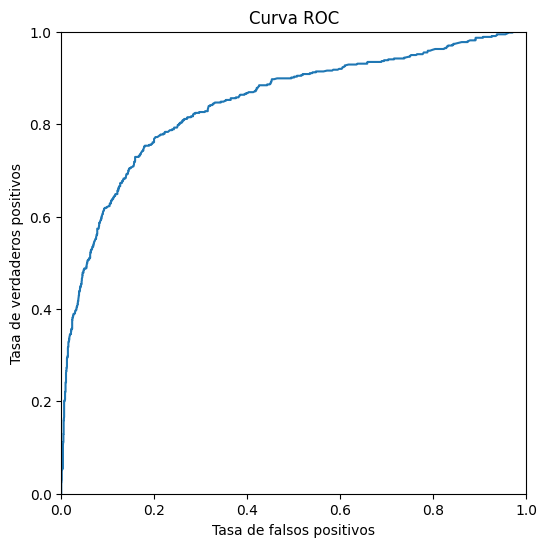

In [47]:
# Primero hace una predicción con el umbral ya optimizado
final_predictions = (probabilities_one_valid >= best_threshold).astype(int)

# Calculamos nuestro F1 final con el umbral de 0.42
final_f1 = f1_score(target_valid, final_predictions)

print(f"F1-score Final: {final_f1:.4f}")

# Calculamos nuestro puntaje AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Calculamos nuestro valor auc-roc

print(f"El puntaje de UC-ROC es de: {auc_roc}")

# Calculamos nuestra curva ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

"""
La curva ROC se genera evaluando diferentes umbrales de decisión y viendo cómo cambian fpr y tpr.
Ejemplo: 
fpr = [0.0, 0.1, 0.2, 0.4, 0.6, 1.0]
tpr = [0.0, 0.5, 0.7, 0.9, 0.95, 1.0]
thresholds = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]
"""
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)

plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.title('Curva ROC')

plt.show()

**Interpretación de AUC-ROC**

AUC-ROC interpreta qué tan bien el modelo distingue entre clases:
- Si el valor es cercano a 1.0 significa que el modelo clasifica casi perfectamente.
- Si el valor es cercano a 0.5 significa que el modelo no diferencia mejor que el azar. 
- Si el valor es cercano a 0.0 significa que el modelo clasifica mal (predice lo opuesto).

Gracias a la gráfica de nuestra curva ROC, podemos ver que a primera vista tenemos un buen clasificador y con el puntaje de 0.84 para AUC-ROC, podemos confirmarlo. Sin duda nuestro modelo es muy bueno para clasificar clases pero es capaz de mejorar.

# Conclusión final

A lo largo del proyecto, desarrollamos un modelo de Machine Learning capaz de predecir la deserción de clientes en Beta Bank. Inicialmente, identificamos un desequilibrio en las clases, lo que afectó el rendimiento del modelo. Para mejorar la precisión y el balance entre precisión y recall, aplicamos estrategias como el ajuste de pesos en las clases (class_weight='balanced') y la optimización del umbral de decisión.

El mejor modelo obtenido fue un Random Forest Classifier con 7 estimadores y una profundidad máxima de 6, alcanzando un F1-score de 0.6310 en el conjunto de validación, superando el umbral mínimo requerido de 0.59. Además, el análisis con la curva AUC-ROC resultó en un valor de 0.844, indicando una buena capacidad del modelo para diferenciar entre clientes que abandonan y los que permanecen.

En conclusión, logramos desarrollar un modelo efectivo para predecir la deserción de clientes, proporcionando a Beta Bank una herramienta valiosa para implementar estrategias de retención y optimizar su gestión de clientes. Sin embargo, hay margen de mejora explorando técnicas avanzadas como redes neuronales o ingeniería de características más profunda.